# Clustering of CBC Data in Madison, WI (1907 - 2024)

## Intro

The goal here is to see which birds in the CBC have similar patterns. We'll do
this by using KMeans clustering over the timeseries datasets. The CBC data is a human-compiled aggregation of observations taken during the CBC every year.

We have two facets we can compare: total bird count vs number by party hours. (The latter is an attempt at normalization).

The input file is a CSV made using transform code taken from Jer Thorpe from raw CBC data files that contains only the timeseries data and excludes the other facets. 

## Quick process overview

The extremely simplified process is this:

1. have some data
2. cluster it
3. see which data corresponds to which cluster

If we spell it out more:

1. Have a set of timeseries data: your X is time, your Y is whatever. In our case, our X is the years from 1907 to 2024, and our Y represents how many birds counted (whether by absolute count or party hour)
2. Split that timeseries out into a series of dataframes; each one has an X of the exact same year set, and each dataframe corresponds to a *specific bird's data*.
   1. Ensure that each dataframe has the exact same set of years for the X's. (or more explicitly, the same LENGTH, but in this case what is more meaningful is the same set of years, which in turn guarantees the same dimensionality for the range of X). In our case, one dataset was missing a year, so we just added it manually.
   2. Ensure you're handling any nullish values somehow, otherwise you'll end up with `nan` and all the issues that happen when that propagates. In our case, we coerce to -1.
3. Given the range of numbers you're considering for the number of clusters for the KMeans, calculate the inertia("the spread/variation of data points around the mean") for each possible cluster size.
4. Pick cluster count at the "elbow" out of your inertia data. (the cluster count after which more clusters don't really do much, ie diminishing returns)
5. Calculate the labels (clusters) for the all the timeseries data. When then indexed against our list of birds, this tells us which bird data is in what cluster.

## The guts of it

### Transforming the data

The first thing we need to do is pull in our json, and transform it to dataframes.

From this, we get two things: the set of all dataframes by bird, as well as the list of bird names. It's important to note that these correspond by index: that is, `bird_names[0]` is the name of the bird that represents the data at `all_bird_series[0]`

In [1]:
from main import get_filename
from transform_helpers import json_to_dataframes

json_path = "/data/raw/bird_map_as_json.json"
input_filename = get_filename("/data/raw/bird_map_as_json.json")

(all_bird_series, bird_names) = json_to_dataframes(input_filename)

We can look at the results of this and see both a series of X/Y coordinates and the list of bird names.

In [2]:
print(all_bird_series[1:5])

[         y_how_many
x_years            
1907             -1
1911             -1
1913             -1
1918             -1
1919             -1
...             ...
2019             -1
2020             -1
2021             -1
2022              2
2023              4

[91 rows x 1 columns],          y_how_many
x_years            
1907             -1
1911             -1
1913             -1
1918             -1
1919             -1
...             ...
2019             -1
2020             -1
2021             -1
2022             -1
2023              1

[91 rows x 1 columns],          y_how_many
x_years            
1907             -1
1911             -1
1913             -1
1918             -1
1919             -1
...             ...
2019             11
2020             37
2021             37
2022             52
2023             99

[91 rows x 1 columns],          y_how_many
x_years            
1907             -1
1911             -1
1913             -1
1918             -1
1919             -1
...    

Note the `-1` values. We're coercing `None` to be `-1` in this case, since it's
also possible to have had data and simply seen `0`.

In [3]:
print(bird_names[1:5])

['Snow Goose', "Ross's Goose", 'Cackling Goose', 'Canada Goose']


The next thing we can do is peak at our data. Graphs that look almost like barcodes have lots of -1s, aka years with no data.

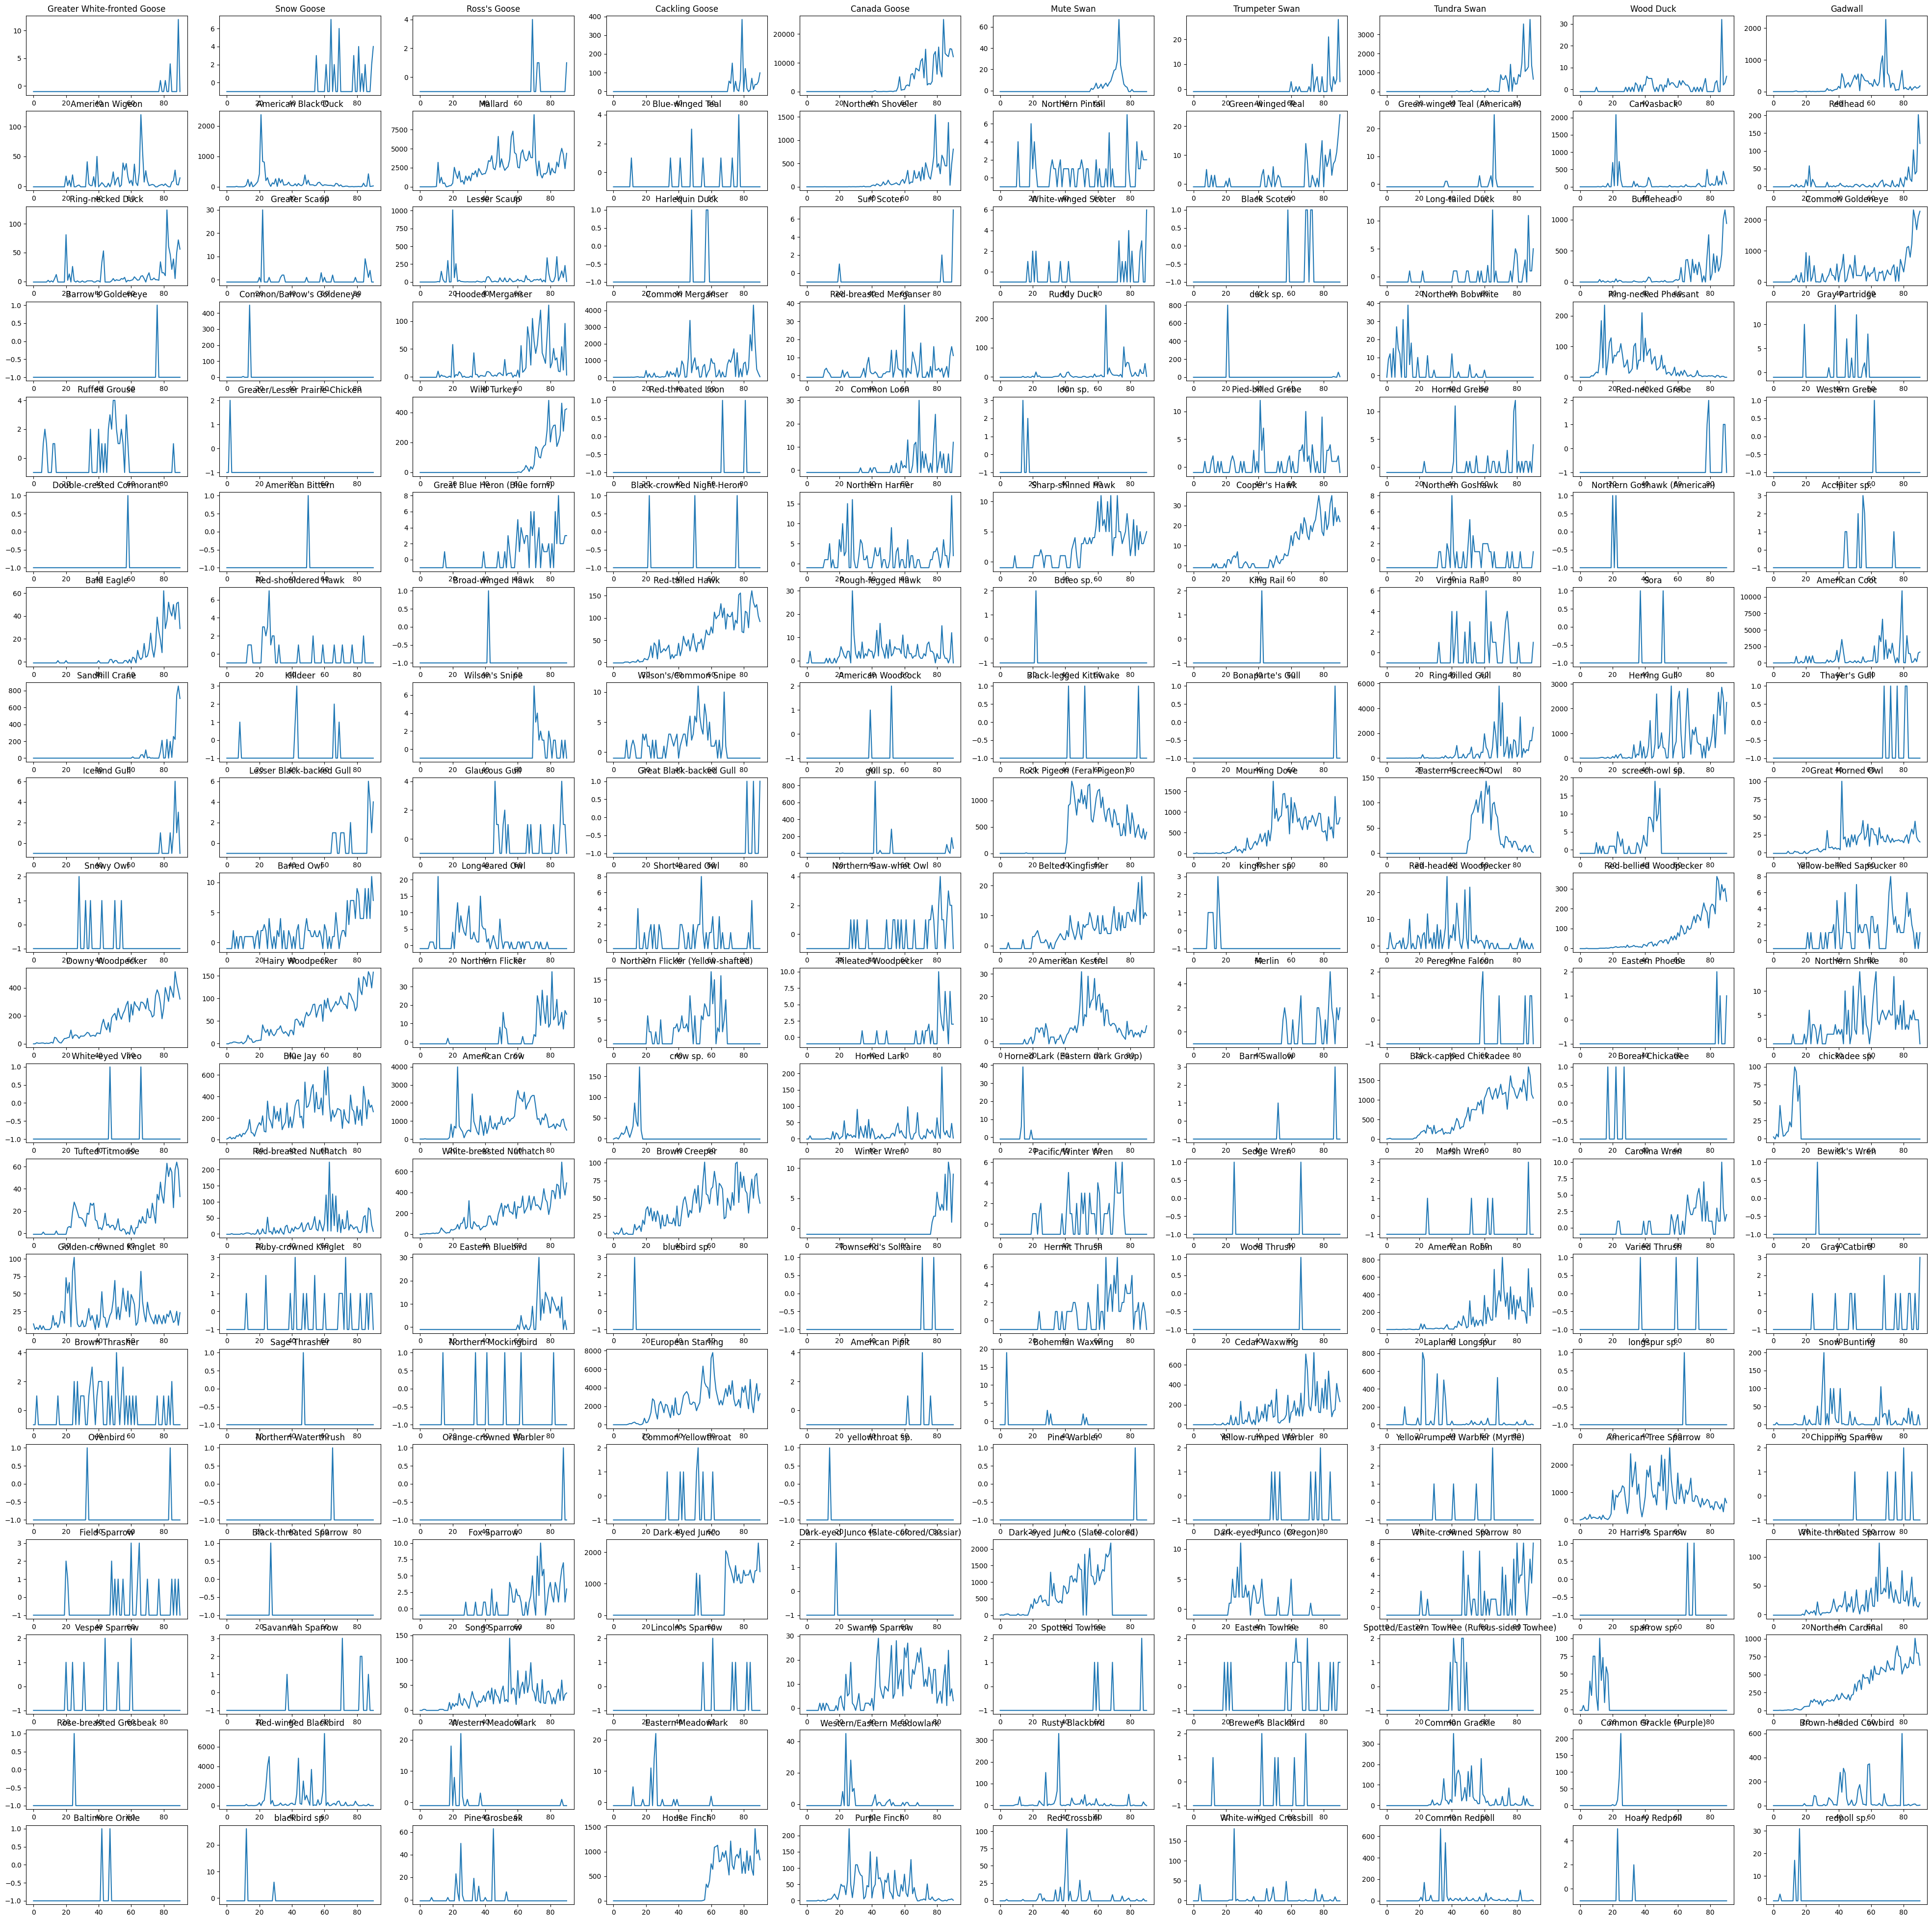

In [4]:
from plotters import render_bird_graphs

render_bird_graphs(all_bird_series, bird_names)

### Selecting cluster count (_k_)

The next step is to pick how many clusters we ultimately want to use. We can do
this by using the "elbow" method, which basically means "compute the inertias
for each possible cluster size, then look at the graph and see where the "elbow"
is in it (the point where adding more clusters is diminishing returns).

To do this, we need to pick some maximal cluster count to work against. The
absolute maximum would be the total number of series we have, which would be one
cluster per dataset; not good. A general rule (that I can't find the source for)
is to use the square root of sample size (i.e., the number of series we have
total). You can always change up your maximal cluster count and see what works best.

By eyeballing the graphs above, we conclude that we just don't have a clue about
what the clusters might be.

(A cool thing is that the elbow method is also used in compressing images -- you
can pick the elbow for picking the minimum number of colors after which there's
no real gain!)

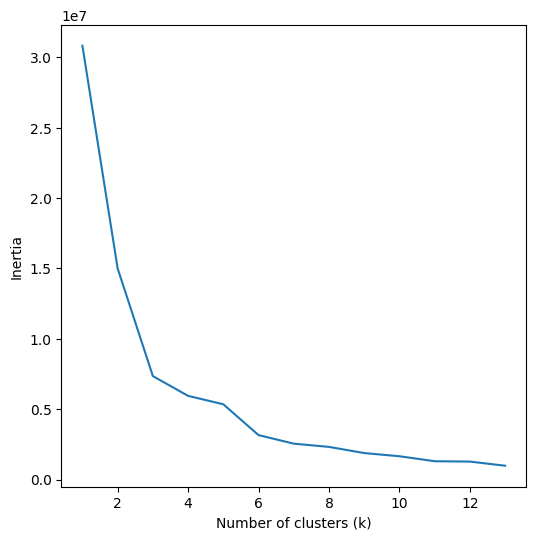

In [5]:
from plotters import render_elbows
import math

# this calculation is arbitrary -- you could set your max cluster count to be 20, 100, etc
max_cluster_count = int(math.sqrt(len(all_bird_series)))

render_elbows(all_bird_series, max_cluster_count=max_cluster_count)

If you run the elbow code above over and over, you'll see you get slightly different graphs.

After some experimenting, we find that 6 seems pretty reasonable.

In [6]:
cluster_count = 6

### Clustering

The next step, perhaps unsurprisingly, is to do the actual clustering.

For this, since we're using timeseries data, we'll use a `TimeSeriesKMeans`. It takes a cluster count, and then a metric. The default metric is Euclidean, and the other two are "dtw" and "softdtw" where dtw stands for "Dynamic Time-Warping". We'll stick to Euclidean for now because the use-case for DTW usually involves timeseries where the time values differ and need to somehow be scaled into alignment. We have the same time values for every dataset.

`fit_predict` both fits and predicts our data. "Fitting" (for kmeans) here means basically creating the cluster 'definitions' (explicitly, it computes the center of each cluster). "Predicting" here means actually assigning clusters to each data set based on. What we get as a result is the set of cluster labels -- a series of cluster indices that correspond to each dataset (and therefore to each bird).

In [7]:
from tslearn.clustering import TimeSeriesKMeans

tskmeans = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")
cluster_labels = tskmeans.fit_predict(all_bird_series)

The first thing we can do is see how many things ended up in each cluster. This
won't tell us the cluster contents, but is a neat way to see how the
classification ended up.

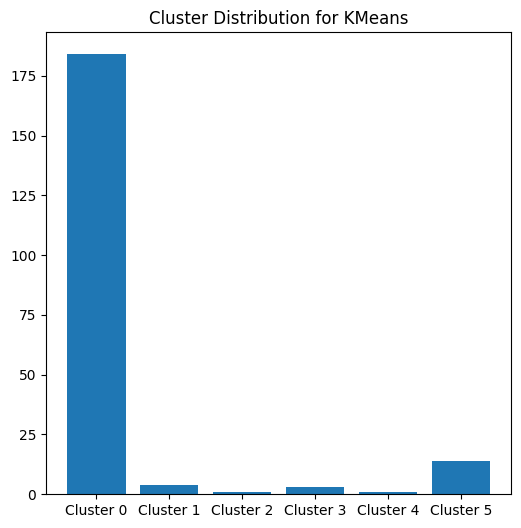

In [8]:
from plotters import render_cluster_counts

render_cluster_counts(cluster_count, cluster_labels)

The next thing we can do to evaluate how well this worked is look at the bird data clustered together, by graphing each set in the cluster together.

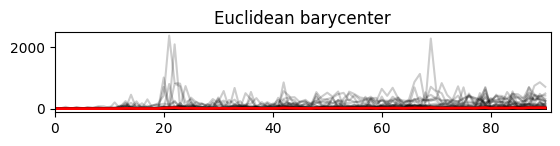

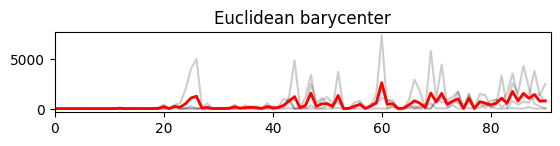

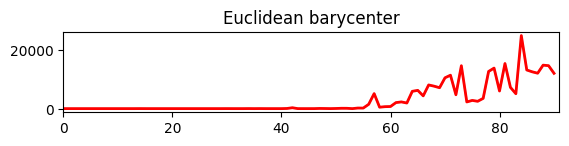

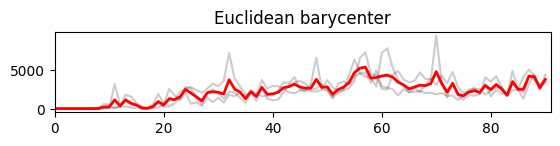

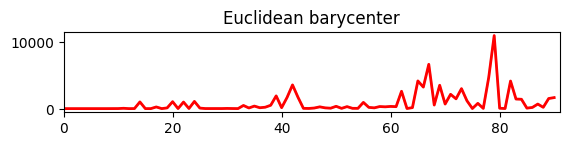

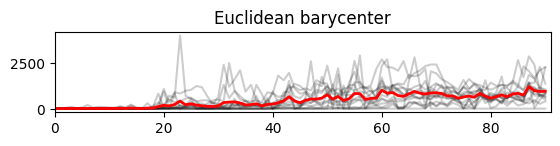

In [9]:
from plotters import render_clusters

render_clusters(
    cluster_labels=cluster_labels,
    cluster_count=cluster_count,
    all_bird_series=all_bird_series,
)